In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:413: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents(s)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(17)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/docrep/__init__.py:342: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [2]:
client

NameError: name 'client' is not defined

_________
# 1. Read dataset


In [5]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_bandpass = xr.open_zarr(out_dir_zarr+'U_bandpass_filter_rechunk.zarr')
ds_V_bandpass = xr.open_zarr(out_dir_zarr+'V_bandpass_filter_rechunk.zarr')
ds_W_bandpass = xr.open_zarr(out_dir_zarr+'W_bandpass_filter_rechunk.zarr')

ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_lowpass_filter_rechunk.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_lowpass_filter_rechunk.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_lowpass_filter_rechunk.zarr')

ds_filter = xr.merge([ds_U_bandpass,ds_V_bandpass,ds_W_bandpass,ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,grid])
ds_filter = generate_grid_ds(ds_filter, {'Z':'depth'})

print(ds_filter)

<xarray.Dataset>
Dimensions:            (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * depth              (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 ...
    dxC                (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyG                (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dzt                (depth) float64 dask.array<shape=(52,), chunksize=(1,)>
  * lat                (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 ...
  * lon_g              (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 ...
    rAw                (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
  * time               (time) float64 0.0 0.04167 0.08333 0.125 0.1667 ...
    dxG                (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyC                (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
  

In [6]:
gridx = xgcm.Grid(ds_filter, coords={'X':{'center':'lon', 'left':'lon_g'},
                                     'Y':{'center':'lat', 'left':'lat_g'},
                                     'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon (177) --> left
  * left     lon_g (177) --> center
Y Axis (periodic):
  * center   lat (201) --> left
  * left     lat_g (201) --> center
Z Axis (not periodic):
  * center   depth (52) --> left
  * left     depth_left (52) --> center


In [7]:
# Calculate vertical distances located on the cellboundary
ds_filter.coords['dzc'] = gridx.diff(ds_filter.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds_filter.coords['dzt'] = gridx.diff(ds_filter.depth_left, 'Z', boundary='extrapolate')
ds_filter

<xarray.Dataset>
Dimensions:            (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * depth              (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 ...
    dxC                (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyG                (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dzt                (depth) float64 1.07 1.145 1.308 1.495 1.705 1.94 ...
  * lat                (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 ...
  * lon_g              (lon_g) float64 -18.04 -18.02 -18.0 -17.98 -17.96 ...
    rAw                (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
  * time               (time) float64 0.0 0.04167 0.08333 0.125 0.1667 ...
    dxG                (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyC                (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
  * 

# 2. Calculate PI_omega

## horizontal terms

In [8]:
dU_dx = gridx.diff(ds_filter['U_low_filter'], 'X')/gridx.interp(ds_filter.dxG, 'Y')
dU_dx

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [9]:
dU_dy_1 = gridx.diff(ds_filter['U_low_filter'], 'Y')/gridx.interp(ds_filter.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
dU_dy = gridx.interp(dU_dy_2, 'Y')
dU_dy

<xarray.DataArray 'mul-ba0a62a1406a26f2fd6afdb413c3229b' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 1)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [10]:
dV_dx_1 = gridx.diff(ds_filter['V_low_filter'], 'X')/gridx.interp(ds_filter.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dV_dx = gridx.interp(dV_dx_2, 'Y')
dV_dx

<xarray.DataArray 'mul-24a65c1e14996a4174b619c2f7099afe' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 1)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [11]:
dV_dy = gridx.diff(ds_filter['V_low_filter'], 'Y')/gridx.interp(ds_filter.dyG, 'X')
dV_dy

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [12]:
u_prime = gridx.interp(ds_filter.U_bandpass_filter, 'X')
u_prime

<xarray.DataArray 'mul-722eead9dec526fbb92475e8d2ede23e' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [13]:
v_prime = gridx.interp(ds_filter.V_bandpass_filter, 'Y')
v_prime

<xarray.DataArray 'mul-c8a47035bafbcf5781fd061a891b9c66' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [14]:
Pi_h = -(u_prime * u_prime * dU_dx + u_prime * v_prime * dU_dy + u_prime * v_prime * dV_dx + v_prime * v_prime * dV_dy)
Pi_h

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 1)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [15]:
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
Pi_h = Pi_h.chunk(chunks)
Pi_h = np.real(Pi_h).rename('Pi_h')
Pi_h = Pi_h.to_dataset()
file_out = out_dir_zarr+'/Pi_horizontal_rechunk.zarr'
%time Pi_h.to_zarr(file_out, mode='w')   

CPU times: user 42.3 s, sys: 2.95 s, total: 45.3 s
Wall time: 2min 36s


# Other terms

In [32]:
KE_submesoscale = 0.5*(u_prime**2 + v_prime**2)
KE_submesoscale

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [33]:
KE_mesoscale = (gridx.interp(ds_filter['U_low_filter']**2,'X') + gridx.interp(ds_filter['V_low_filter']**2,'Y'))/2
KE_mesoscale

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...

In [37]:
dKEs_dt = (KE_submesoscale.shift(time=-1) - KE_submesoscale.shift(time=1) )/2/3600
dKEm_dt = (KE_mesoscale.shift(time=-1) - KE_mesoscale.shift(time=1) )/2/3600

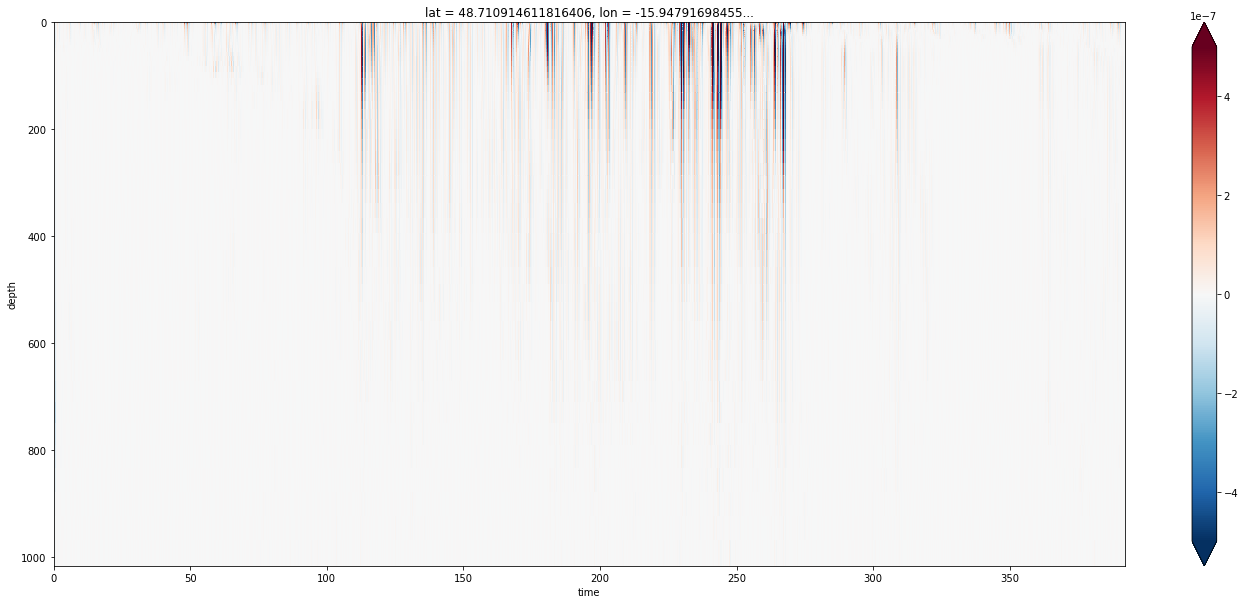

In [40]:
fig = plt.figure(figsize=(24,10))
dKEs_dt.isel(lat=100,lon=100).plot(x='time', y='depth',cmap='RdBu_r',vmin=-5e-7,vmax=5e-7,yincrease=False)

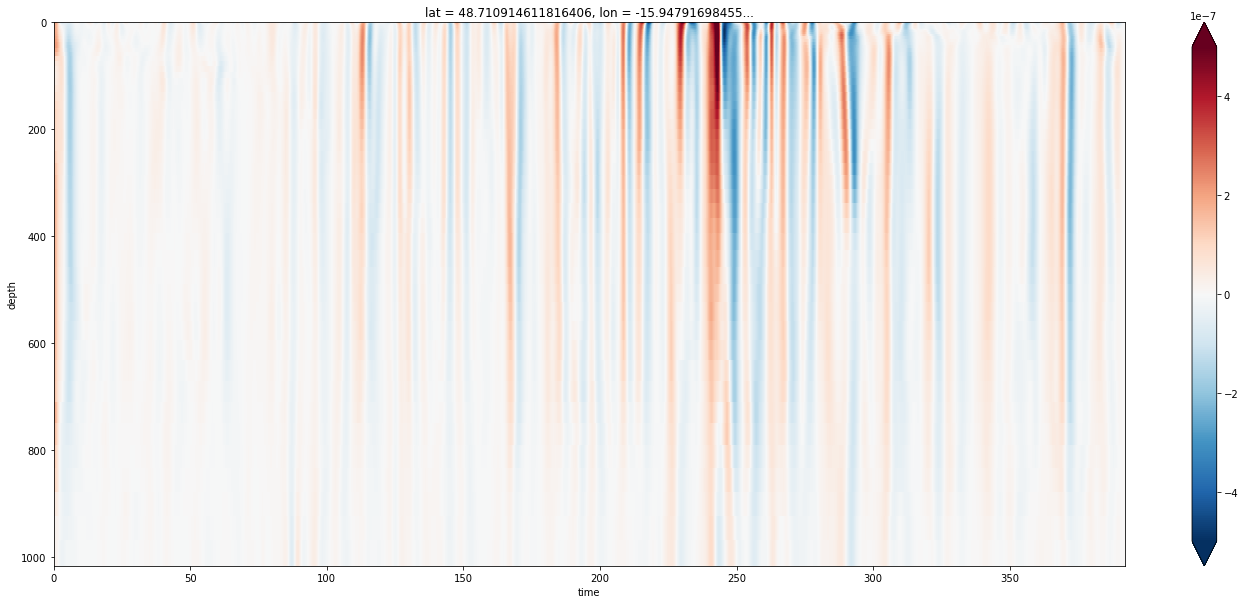

In [41]:
fig = plt.figure(figsize=(24,10))
dKEm_dt.isel(lat=100,lon=100).plot(x='time', y='depth',cmap='RdBu_r',vmin=-5e-7,vmax=5e-7,yincrease=False)

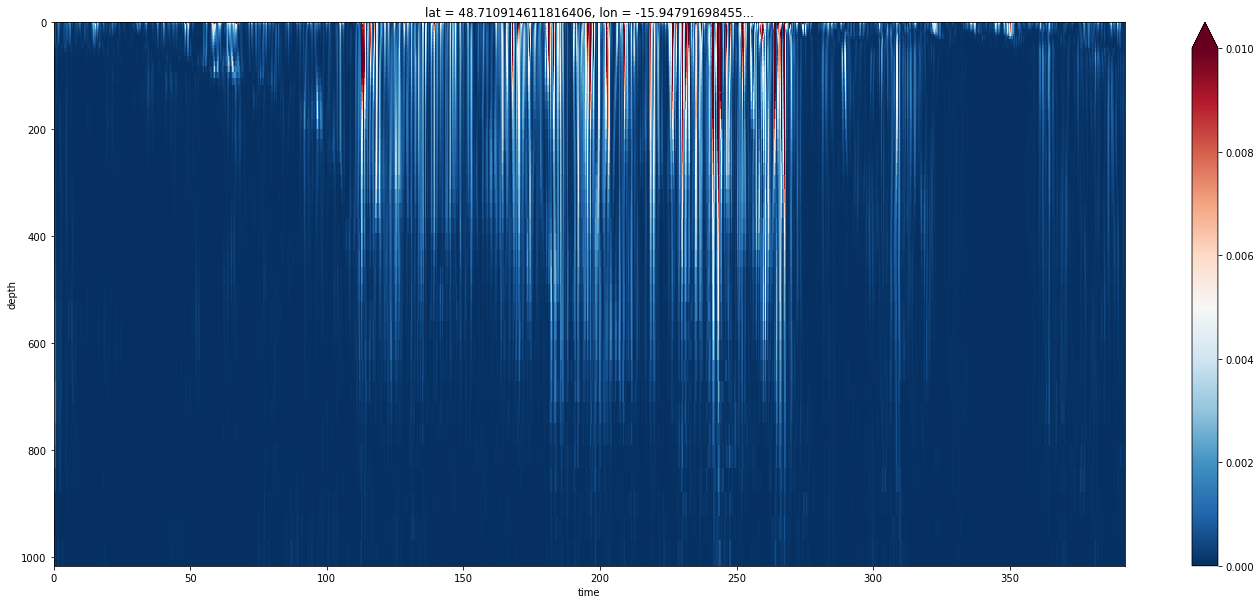

In [46]:
fig = plt.figure(figsize=(24,10))
KE_submesoscale.isel(lat=100,lon=100).plot(x='time', y='depth',cmap='RdBu_r', vmin=0,vmax=0.01,yincrease=False)

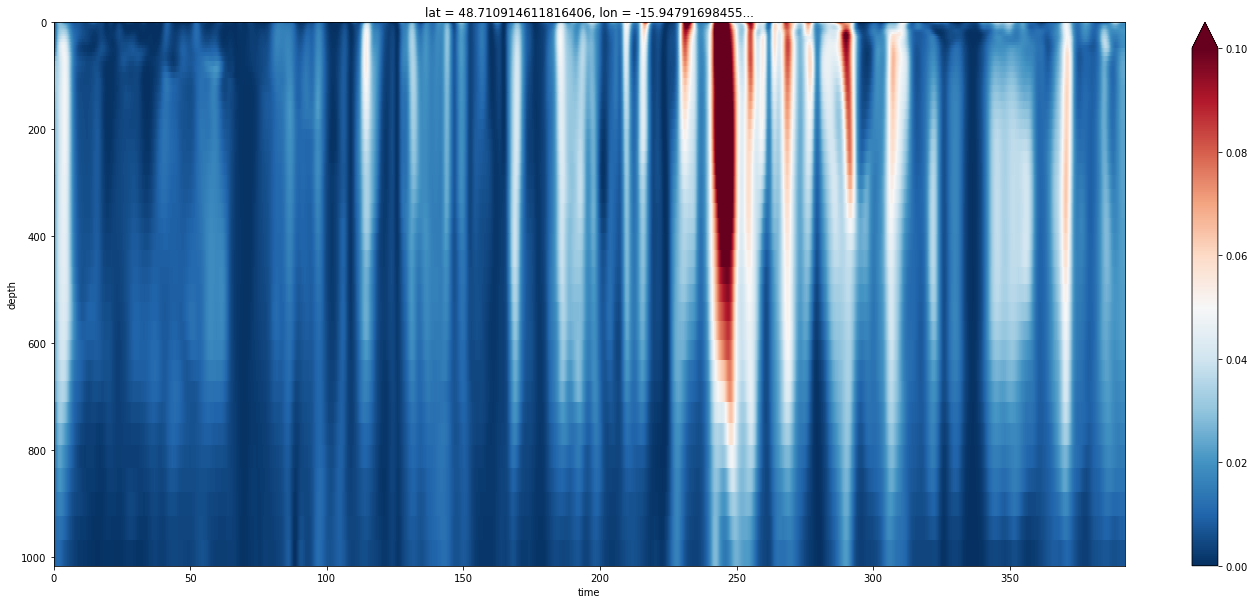

In [35]:
fig = plt.figure(figsize=(24,10))
KE_mesoscale.isel(lat=100,lon=100).plot(x='time', y='depth',cmap='RdBu_r', vmin=0,vmax=0.1,yincrease=False)

# 3. Read PI_omega (h) results

In [22]:
Pi_h = xr.open_zarr(out_dir_zarr+'Pi_horizontal_rechunk.zarr')
print(Pi_h)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    Pi_h     (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(9415, 1, 201, 177)>


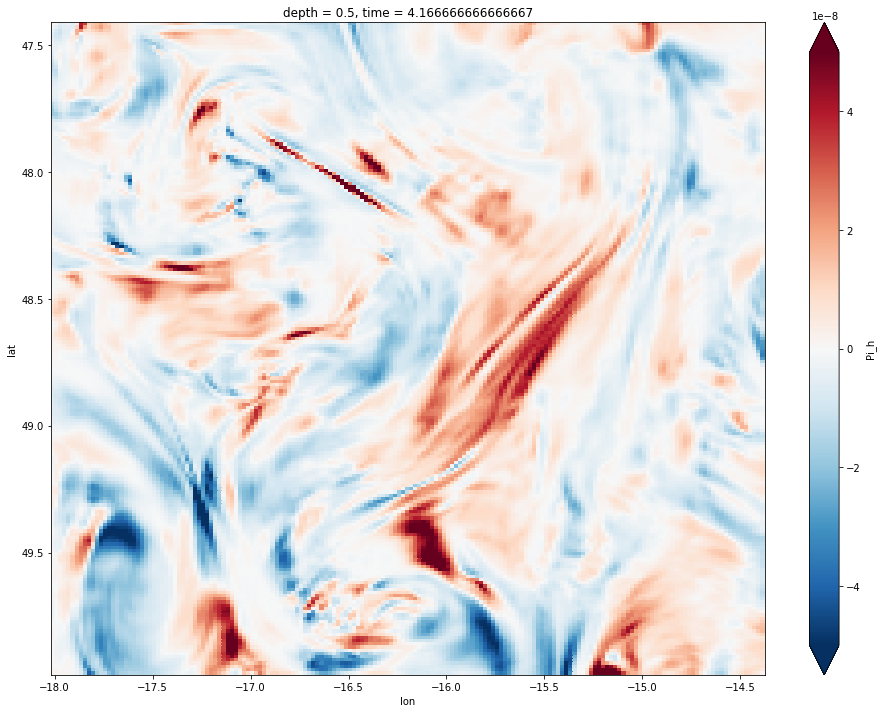

In [29]:
fig = plt.figure(figsize=(16,12))
Pi_h.Pi_h.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0,time=100).plot(x='lon', y='lat',cmap='RdBu_r', vmin=-5e-8,vmax=5e-8,yincrease=False)

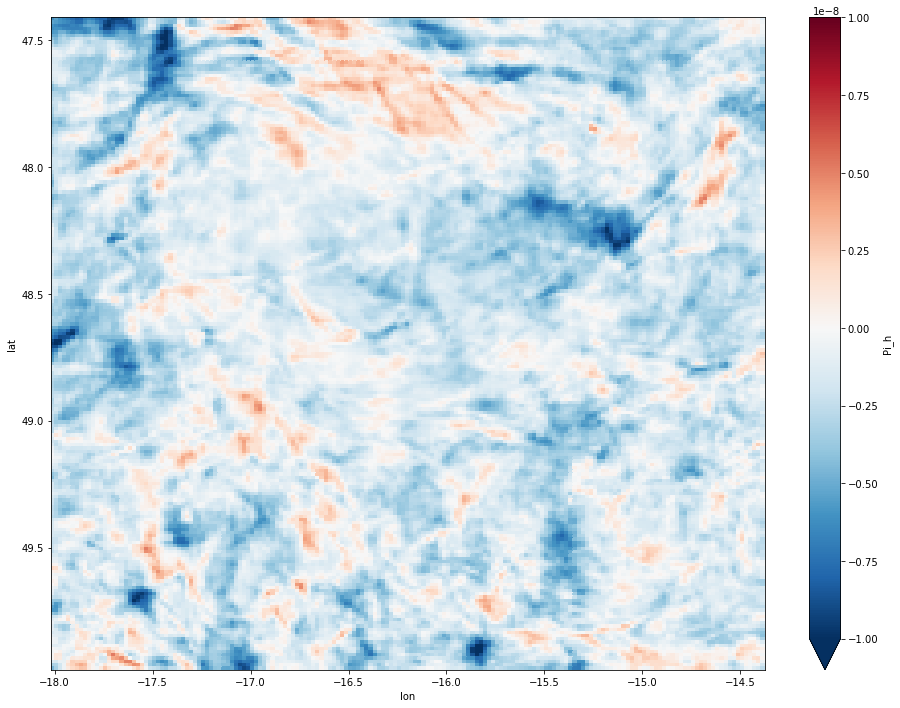

In [31]:
fig = plt.figure(figsize=(16,12))
Pi_h.Pi_h.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['depth','time']).plot(x='lon', y='lat',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)

distributed.client - WARNING - Couldn't gather 3 keys, rescheduling {"('transpose-7039f0a8f859965e2bc3d595df7b0aeb', 49, 0)": (), "('transpose-7039f0a8f859965e2bc3d595df7b0aeb', 51, 0)": (), "('transpose-7039f0a8f859965e2bc3d595df7b0aeb', 50, 0)": ()}


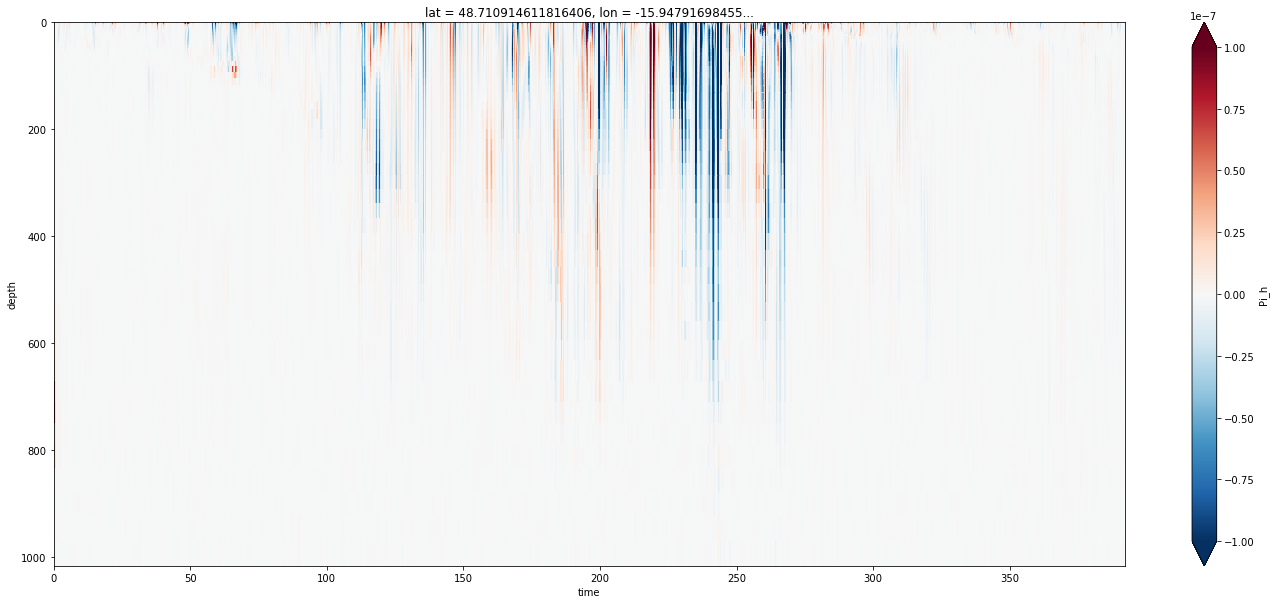

In [25]:
fig = plt.figure(figsize=(24,10))
Pi_h.Pi_h.isel(lat=100,lon=100).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-7,vmax=1e-7,yincrease=False)

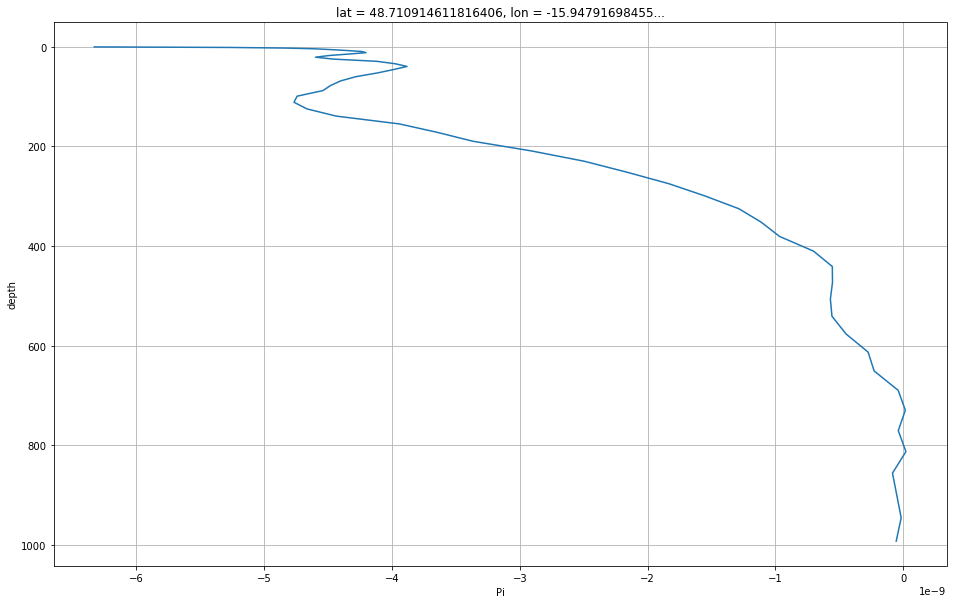

In [82]:
fig, ax = plt.subplots(figsize=(16,10))
Pi_h.Pi.isel(lat=100,lon=100).mean(['time']).plot(y='depth', yincrease=False)
ax.grid()

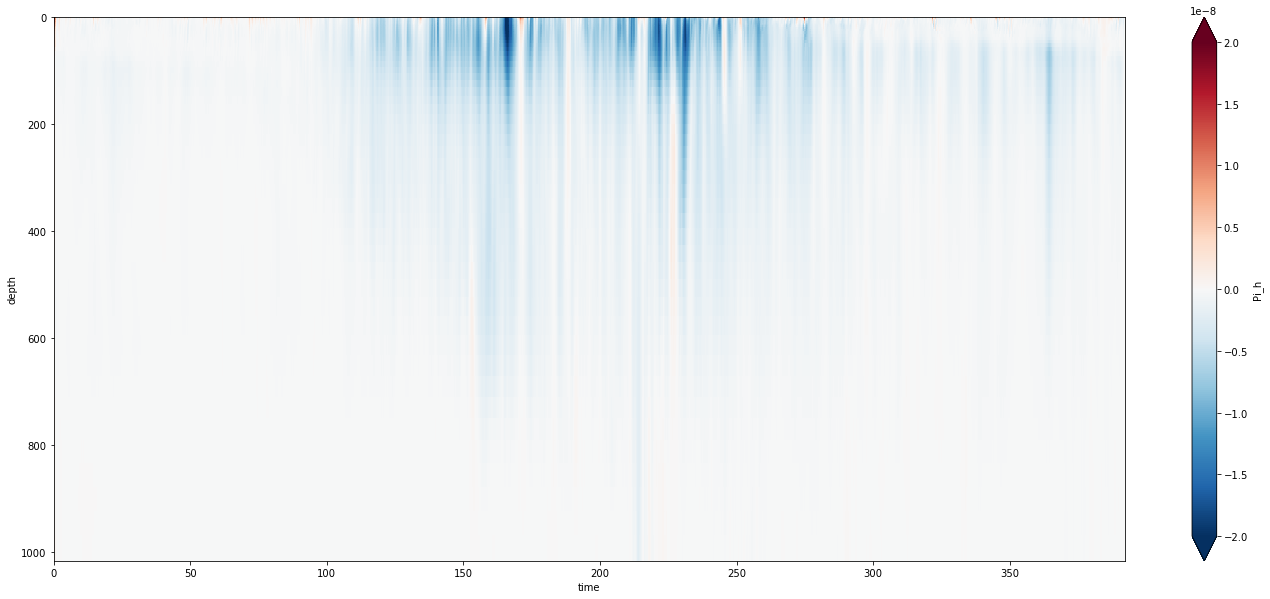

In [25]:
fig = plt.figure(figsize=(24,10))
Pi_h.Pi_h.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lat','lon']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False)

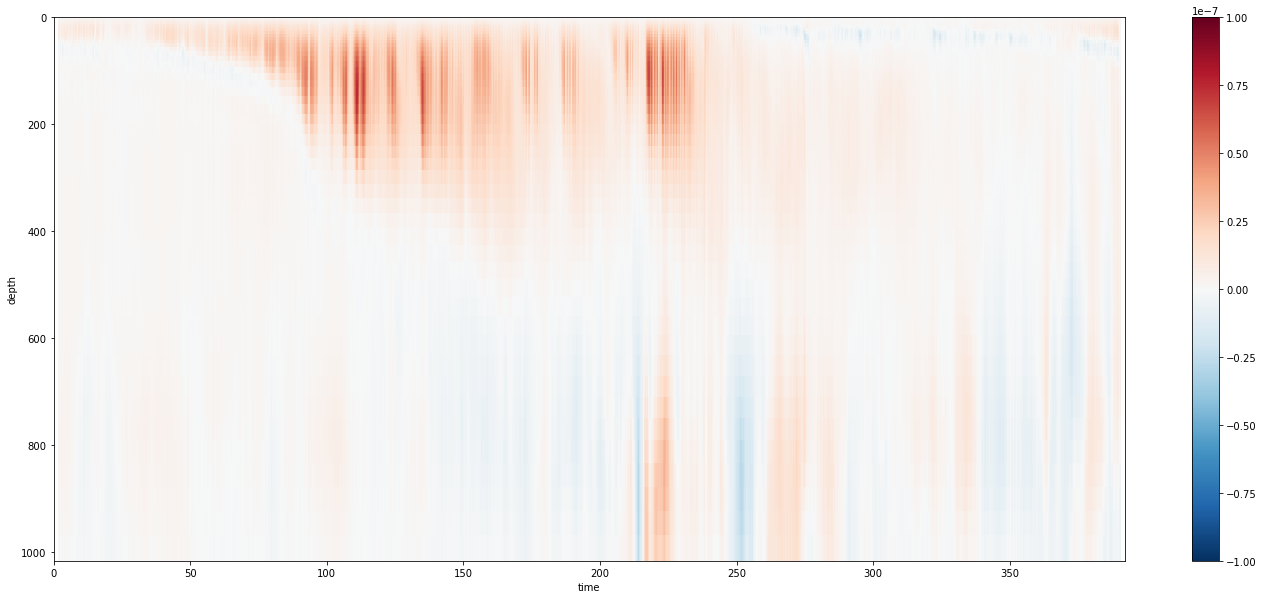

In [44]:
fig = plt.figure(figsize=(24,10))
wb_prime_mean.plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False)

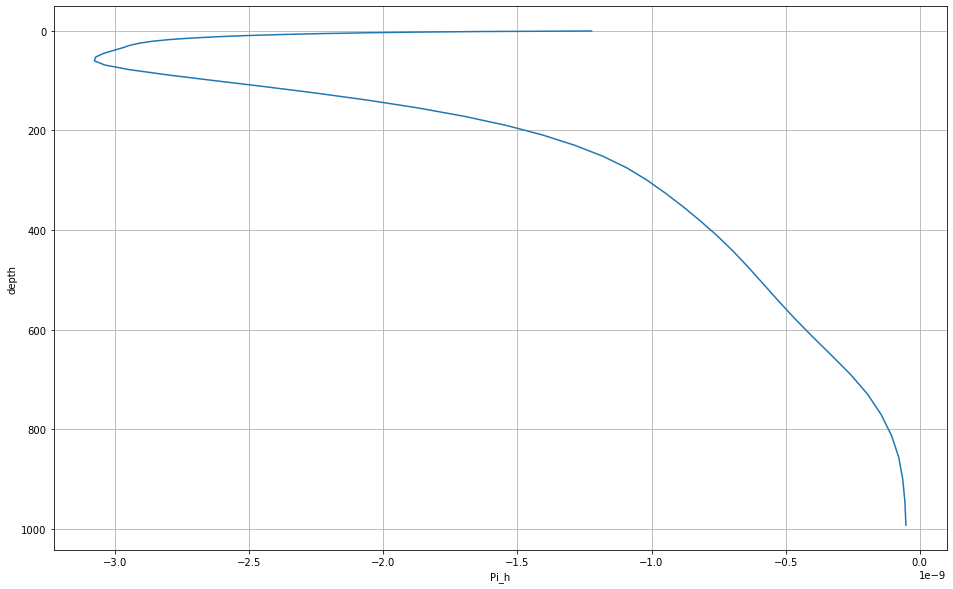

In [26]:
fig, ax = plt.subplots(figsize=(16,10))

Pi_h.Pi_h.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['time','lat','lon']).plot(y='depth', yincrease=False)
ax.grid()

In [48]:
cluster.scheduler.close()

<Future finished result=None>